In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('processed.xlsx')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


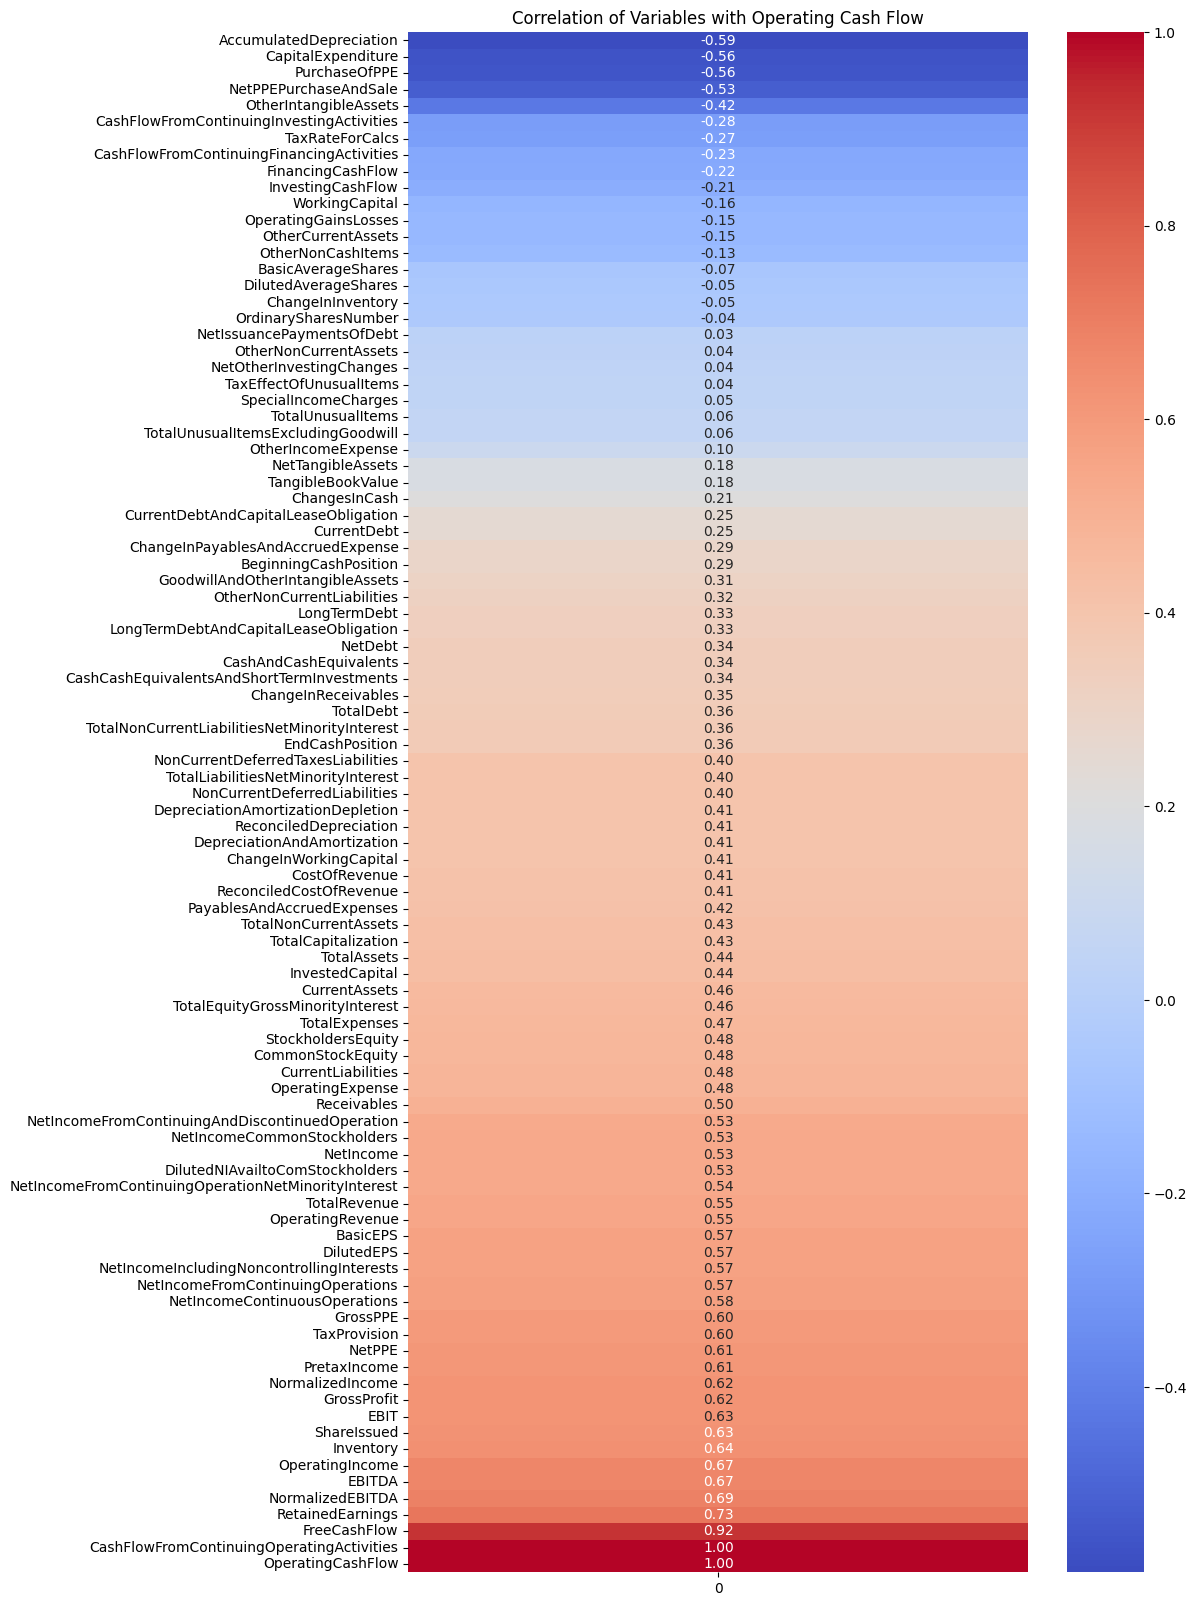

In [3]:
correlation = data.corr()["OperatingCashFlow"].sort_values()

# Fix the heatmap plot issue by converting to a numpy array
plt.figure(figsize=(10, 20))
sns.heatmap(correlation.values[:, None], annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            yticklabels=correlation.index)
plt.title('Correlation of Variables with Operating Cash Flow')
plt.show()

In [4]:
features = ["NetIncome", "GrossProfit", "EBITDA", "RetainedEarnings", "TotalRevenue", "OperatingIncome", "ChangeInWorkingCapital"]
target = 'OperatingCashFlow'

In [5]:
selected_data = data[features + [target]]
selected_data = selected_data.dropna()

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_data)
scaled_data = pd.DataFrame(scaled_data, columns=selected_data.columns)

In [7]:
def create_sequences(input_data, target_column, sequence_length):
    sequences = []
    target = []
    for i in range(len(input_data) - sequence_length):
        sequences.append(input_data[i:(i + sequence_length)].values)
        target.append(input_data.iloc[i + sequence_length][target_column])
    return np.array(sequences), np.array(target)

In [8]:
sequence_length = 8
X, y = create_sequences(scaled_data, target, sequence_length)

In [9]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(20, return_sequences=False),
    Dense(1)
])

In [11]:
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     hyperband_iterations=2)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_test, y_test),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
LSTM layer is {best_hps.get('units')} and the optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 180 Complete [00h 00m 13s]
val_loss: 0.05620599165558815

Best val_loss So Far: 0.05236148089170456
Total elapsed time: 00h 38m 38s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
LSTM layer is 128 and the optimal dropout rate is 0.45.
The optimal learning rate for the optimizer is 0.01.



In [12]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
4/4 [==============================] - 6s 464ms/step - loss: 0.7129 - val_loss: 0.2681
Epoch 2/50
4/4 [==============================] - 0s 39ms/step - loss: 0.0588 - val_loss: 0.0926
Epoch 3/50
4/4 [==============================] - 0s 36ms/step - loss: 0.0197 - val_loss: 0.0818
Epoch 4/50
4/4 [==============================] - 0s 30ms/step - loss: 0.0170 - val_loss: 0.0703
Epoch 5/50
4/4 [==============================] - 0s 32ms/step - loss: 0.0199 - val_loss: 0.0549
Epoch 6/50
4/4 [==============================] - 0s 31ms/step - loss: 0.0171 - val_loss: 0.0530
Epoch 7/50
4/4 [==============================] - 0s 35ms/step - loss: 0.0158 - val_loss: 0.0898
Epoch 8/50
4/4 [==============================] - 0s 31ms/step - loss: 0.0132 - val_loss: 0.0533
Epoch 9/50
4/4 [==============================] - 0s 36ms/step - loss: 0.0147 - val_loss: 0.0525
Epoch 10/50
4/4 [==============================] - 0s 33ms/step - loss: 0.0116 - val_loss: 0.0807
Epoch 11/50
4/4 [===========

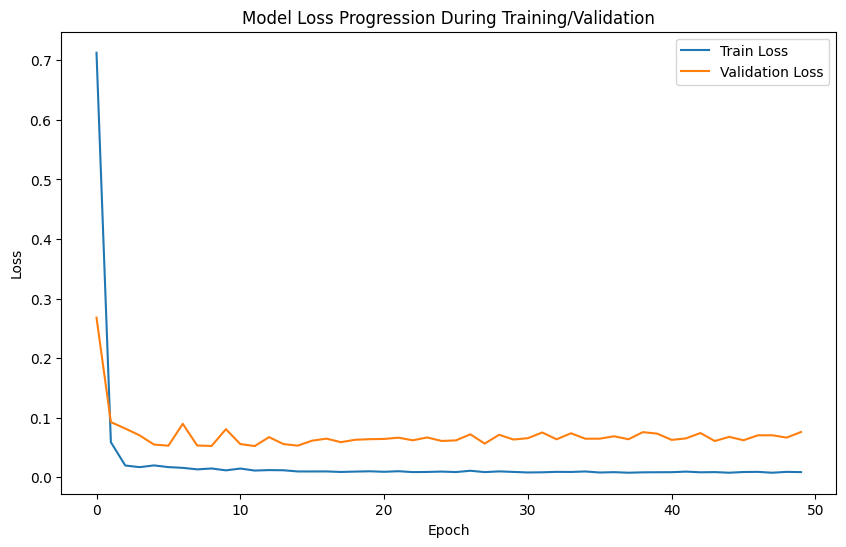

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.07602019608020782


In [15]:
test_predictions = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [25]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, test_predictions)
print(f'Mean Absolute Error on Test Data: {mae}')

mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error on Test Data: 25%')

Mean Absolute Error on Test Data: 0.1976939940715561
Mean Absolute Percentage Error on Test Data: 25%


C:\Users\rohit\AppData\Local\Temp\ipykernel_16984\2116844555.py:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100


In [26]:
comparisons_scaled = pd.DataFrame({
    'Actual Values (Scaled)': y_test.flatten(),
    'Predicted Values (Scaled)': test_predictions.flatten()
})
print(comparisons_scaled)


    Actual Values (Scaled)  Predicted Values (Scaled)
0                 0.842615                   0.788352
1                 0.458111                   0.775758
2                 0.745924                   0.793672
3                 0.886683                   0.790902
4                 0.791768                   0.799031
5                 0.585956                   0.796162
6                 0.955448                   0.810143
7                 0.818725                   0.812447
8                 0.846812                   0.827008
9                 0.563680                   0.824805
10                0.851170                   0.843459
11                0.000000                   0.836108
12                0.550928                   0.848351
13                0.484907                   0.803561
14                0.738176                   0.815090
15                0.412107                   0.766980
16                0.493947                   0.724523
17                0.238418  